In [59]:
%reload_ext autoreload
%autoreload 2

import torch

import numpy as np
import matplotlib.pyplot as plt

from datasets import *
from models import *
from losses import *

In [68]:
data_generator = GaussianDataset()

data_generator.generate_data(5000, 1)
train_loader = torch.utils.data.DataLoader(data_generator, batch_size=500, shuffle=True)

print('mean:', round(torch.mean(data_generator.y).item(), 2), 'std:', round(torch.std(data_generator.y).item(), 2))

data_generator.generate_data(1000, 1)
test_loader = torch.utils.data.DataLoader(data_generator, batch_size=500, shuffle=True)

mean: -0.47 std: 0.92


In [69]:
model = VI()

In [73]:
epochs = 2000
optim = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(epochs):
    for X, y in train_loader:
        optim.zero_grad()
        y_pred, mu, log_var, weights = model(X)
        loss = elbo_gm(y_pred, y, mu, log_var, weights)
        loss.backward()
        optim.step()

In [74]:
# print the parameters of the model
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

q_mu.0.weight tensor([[ 0.1610],
        [-0.1283],
        [-0.6783],
        [-0.3897],
        [-0.1699],
        [-0.6713],
        [-1.1723],
        [ 0.6668],
        [-0.0228],
        [-0.6037],
        [-0.1994],
        [ 1.3333],
        [-0.0306],
        [ 0.5114],
        [-0.5883],
        [-0.8258],
        [-0.3835],
        [ 0.7221],
        [-0.8781],
        [-0.5095]])
q_mu.0.bias tensor([-0.3977,  0.1914,  0.9027,  0.3472,  0.5858, -0.6404,  0.7315,  0.9194,
        -0.4286, -0.5746,  0.7799, -0.4527, -0.0086,  0.3179, -0.6862,  0.5138,
        -0.6958,  0.1495,  0.7925, -0.0216])
q_mu.2.weight tensor([[-0.1500,  0.1167,  0.2166, -0.0550,  0.2596,  0.1410, -0.5149,  0.2292,
          0.1301,  0.0482,  0.1109,  0.3222,  0.0560,  0.1486, -0.2118, -0.3982,
         -0.2088, -0.0421, -0.2452,  0.1033],
        [-0.0966, -0.2115,  0.0441,  0.2174, -0.1872, -0.0856, -0.0234, -0.1560,
          0.0161, -0.1549,  0.0046, -0.1630, -0.0441,  0.2072,  0.1888, -0.1277,
    

likelihood: tensor(1.1371)
log_prior: tensor(3.8705)
log_p_q: tensor(0.9145)
elbo: tensor(1.2710)
likelihood: tensor(1.1358)
log_prior: tensor(3.8118)
log_p_q: tensor(0.9124)
elbo: tensor(1.2550)


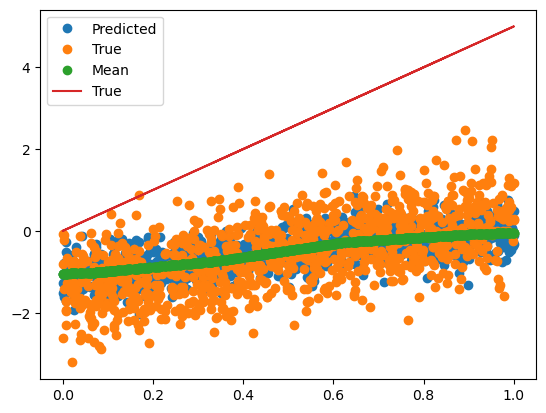

In [75]:
X_test_list, y_test_list, y_pred_list, mu_pred_list = [], [], [], []
with torch.no_grad():
    for X, y in test_loader:
        X_test_list += X.flatten().tolist()
        y_test_list += y.flatten().tolist()
        y_pred, mu, log_var, weights = model(X)
        y_pred_list += y_pred.flatten().tolist()
        mu_pred_list += mu.mean(dim=1).flatten().tolist()
        if nll_gm(y, mu, log_var, weights).mean() < 0:
            print(nll_gm(y, mu, log_var, weights).mean())
        elbo_gm_eval(y_pred, y, mu, log_var, weights)

plt.plot(X_test_list, y_pred_list, 'o', label='Predicted')
plt.plot(X_test_list, y_test_list, 'o', label='True')
plt.plot(X_test_list, mu_pred_list, 'o', label='Mean')
plt.plot(X_test_list, np.array(X_test_list)*5, label='True')
plt.legend()
plt.show()

NameError: name 'gaussian' is not defined

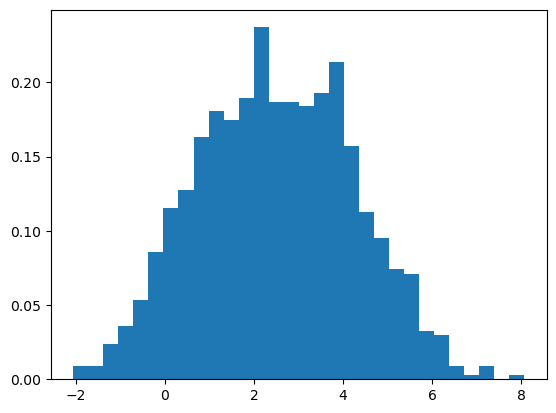

In [20]:
plt.hist(y_test, bins=30, density=True)
plt.plot(np.linspace(-3, 7, 100), gaussian(np.linspace(-3, 7, 100), np.mean(y_test), np.std(y_test)))

In [ ]:
# y_pred, y, mu, log_var

det_loss()

In [66]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) / (sig * np.sqrt(2 * np.pi))

model.eval()
y_pred = []

for i in range(100000):
    y_pred.append(model(X[1])[0].item())

plt.hist(y_pred, bins=100, density=True)
plt.plot(np.linspace(-3, 3, 100), gaussian(np.linspace(-3, 3, 100), X[1].item(), 1))
plt.show()

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)